## Horizontal integration between NCI's Gdata file system and TERN's THREDDS Data Server

The following tutorial will demonstrate how to access and combine datasets from multiple sources using web services in Python. We will extract ASTER data from NCI's Gdata high-performance disk storage (https://nci.org.au/our-services/data-storage) and combine this with OzFlux data from TERN's THREDDS Data Server (https://dap.tern.org.au/thredds/catalog/ecosystem_process/ozflux/catalog.html).

To run this notebook on NCI's [Australian Research Environment (ARE)](https://opus.nci.org.au/display/Help/ARE+User+Guide), you can use either:

- the [dk92 NCI-data-analysis environment](https://opus.nci.org.au/pages/viewpage.action?pageId=134742126)
- the [up99 NCI-geophysics environment](https://opus.nci.org.au/display/DAE/NCI-geophysics) 

### The ASTER dataset

The ASTER geoscience map of Australia is a set of digital geoscience products generated from satellite ASTER data. ASTER (Advanced Spaceborne Thermal Emission and Reflection Radiometer) is a Japanese imaging instrument on board USA’s TERRA satellite. The multispectral imaging sensor is the world’s first “geoscience tuned” satellite Earth Observing System. The ASTER geoscience maps of Australia represent the first continent-scale maps of the Earth’s surface mineralogy.

ASTER has 14 spectral bands spanning wavelengths sensitive to important rock forming minerals, including: Iron oxides; clays; carbonates; quartz; muscovite and chlorite. 

In this example we will be using the "Ferric Oxide Composition" layer.

### The OzFlux dataset

OzFlux is an ecosystem research network as part of the international network [FluxNet](https://fluxnet.org/), which combines over 500 flux stations worldwide. It is designed to provide continuous, long-term micrometeorological measurements to monitor the state of ecosystems globally. The OzFlux towers quantify the fluxes of scalars (e.g., CO2, CH4, water vapor) and energy (e.g., sensible, latent heat) between the biosphere and atmosphere. In addition, continuous measurements of ancillary physical variables (e.g., air temperature, precipitation, radiation) are acquired from a large number of sensors at high temporal resolution. All values are recorded half-hourly and some time series reach back to 2002. 

In this example we will be showing the recorded time series of CO2 and absolute humidity measured at five OzFlux towers.

We will combine 2 different datasets located at different locations using our local file system and a web service endpoint. 

We will load ASTER data directly from NCI's high-performance disk storage Gdata. The OzFlux dataset is hosted on TERN's THREDDS Data Server and we will access it through the [OpenDAP](https://www.opendap.org/) endpoint using the [NetCDF4](https://unidata.github.io/netcdf4-python/) library. 

Additionally, the following Python3 libraries are used by this notebook, for which we have included links to their reference documentation:

- [numpy](https://numpy.org/)
- [matplotlib.pyplot](https://matplotlib.org/stable/tutorials/introductory/pyplot.html)
- [xarray](https://docs.xarray.dev/en/stable/)
- [NetCDF4](https://unidata.github.io/netcdf4-python/)

Firsly, we import the necessary libraries, and specify where to save output figures:

In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import netCDF4 as nc
%matplotlib inline
save_folder='<insert_a_directory_that_you_have_write_access_to'  ### (e.g., '/home/500/abc500')

### Access TERN OzFlux Data from TERN's Thredds using the OpenDAP endpoint

Next, we look at how to access the OzFlux dataset using the OpenDAP endpoints and save some variables for later visualisation:

In [2]:
# Access the daily  measurements of the Alice Springs OzFlux station via TERN's Thredds service, using the OpenDAP endpoint 
url='https://dap.ozflux.org.au/thredds/dodsC/ozflux/sites/AliceSpringsMulga/L3/default/AliceSpringsMulga_L3.nc'
dataset = nc.Dataset(url)

# Extract the relevant metadata from the loaded NetCDF file
lat_AS = dataset.variables['latitude'][:]
lon_AS = dataset.variables['longitude'][:]
t_AS = np.squeeze(dataset.variables['time'][:])

# Extract 2 measurements from the loaded NetCDF file
AH_AS = np.squeeze(dataset.variables['AH'][:]) # Humidity
CO2_AS = np.squeeze(dataset.variables['CO2'][:]) # CO2 concentration

# Access the monthly measurements of the Cape Tribulation OzFlux station using the same method
url='https://dap.ozflux.org.au/thredds/dodsC/ozflux/sites/CapeTribulation/L6/default/CapeTribulation_L6_Monthly.nc'
dataset = nc.Dataset(url)

# Extract the relevant metadata from the loaded NetCDF file
lat_CT = dataset.variables['latitude'][:]
lon_CT = dataset.variables['longitude'][:]
t_CT = np.squeeze(dataset.variables['time'][:])

# Extract 2 measurements from the loaded NetCDF file
AH_CT = np.squeeze(dataset.variables['AH'][:]) # Humidity
CO2_CT = np.squeeze(dataset.variables['CO2'][:]) # CO2 concentration

### Access ASTER data via NCI Gdata

Now that we have saved the relevant data of the OzFlux dataset, we move on to the ASTER dataset. We access the ASTER dataset via NCI's high-performance disk storage system Gdata, that currently stores over 150 petabytes of research data:

In [3]:
# Select the wanted dataset - here we go with the NetCDF4 version of the Ferric oxide composition
file_path = "/g/data/wx7/Australian_ASTER_Geosciences_Map_Project/ASTER_VNIR_SWIR_Products/Mineral_Products/BSQ_Files/Aus_Mainland/Aus_Mainland_Ferric_oxide_composition_reprojected.nc4"

# Set maximum and minimum coordinates
lat_min = -35
lat_max = -34
lon_min = 150
lon_max = 151

In [4]:
# Open the dataset extract the layer Ferric_oxide_composition for easier handling
ds = xr.open_dataset(file_path).Ferric_oxide_composition
 
# Pick every 25 value of the dataset to reduce the runtime
ds_new = ds.sel(lat=slice(None, None, 25), lon=slice(None, None, 25))
 
# Now that we are done with all data manipulation, we can load the dataset
ds_new=ds_new.load()

Next, we take a quick look at the histogram to determine a good range for the colorbar later-on.

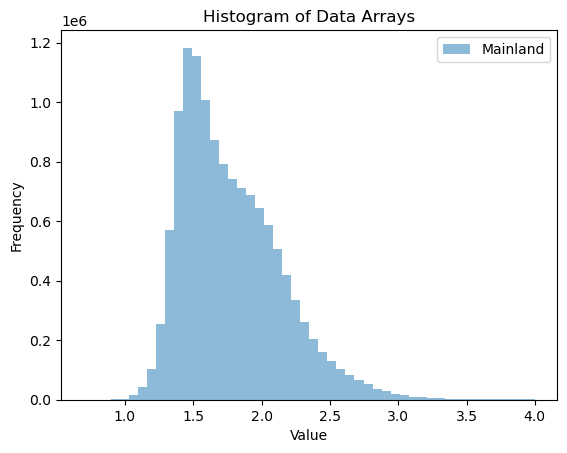

In [5]:
flat_data = ds_new.values.flatten()

plt.hist(flat_data, bins=50, range=(0.7,4), alpha=0.5, label='Mainland')

# Add labels, title, legend, etc.
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Data Arrays')
plt.legend()

# Show the plot
plt.show()

### Create a figure containing the ASTER map and OzFlux locations

Now that we have all the data we need, we plot the ASTER map and add the coordinates of the two example OzFlux towers to it:

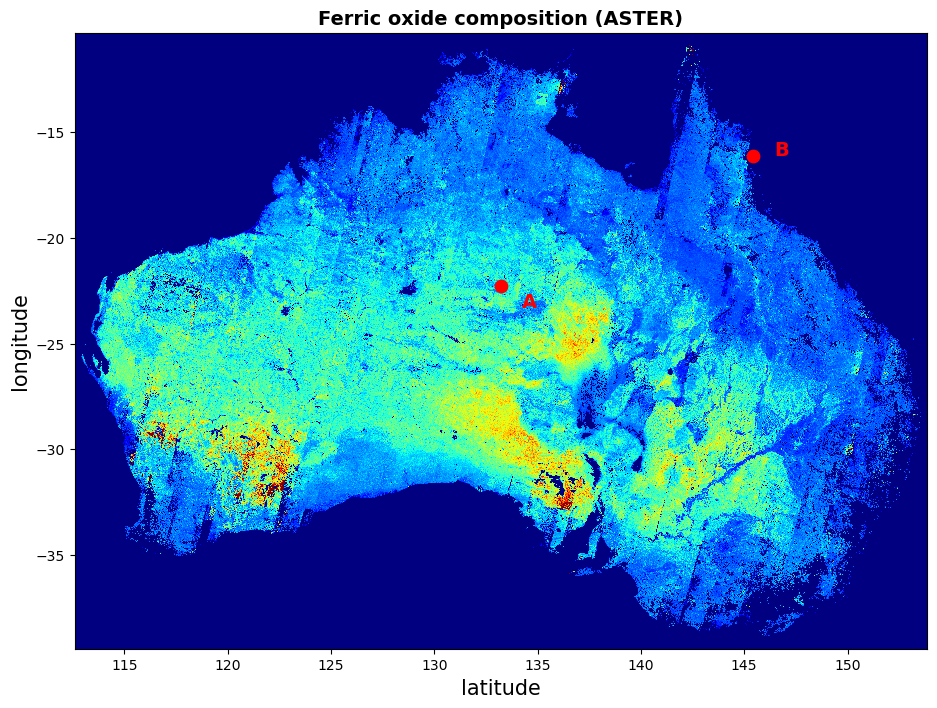

In [6]:
# Set the figure size 
plt.rcParams['figure.figsize'] = [11, 8]  

# Create the plot using the xarray function ds_new.plot()
plot = ds_new.plot(vmin=0.8, vmax=3.7, cmap='jet', add_colorbar=False)

# Set labels
plt.xlabel("latitude", fontsize=15)
plt.ylabel("longitude", fontsize=15)
plt.title('Ferric oxide composition (ASTER)', fontsize=14, fontweight='bold')

# Add coordinates of the two OzFlux datasets to the map
plt.text(lon_AS+1, lat_AS-1, 'A', color='r', fontsize=14, fontweight='bold')
plt.scatter(lon_AS, lat_AS, s=80, color='r')
plt.text(lon_CT+1, lat_CT, 'B', color='r', fontsize=14, fontweight='bold')
plt.scatter(lon_CT, lat_CT, s=80, color='r')

# Save complete figure in the specified save_folder
plt.savefig(save_folder+'Ferric_oxide_composition.png', dpi=200)

### Plot OzFlux measurements from Alice Springs (point A on map)

Now let's also plot the example OzFlux measurements from Alice Springs (point A on map) that we saved earlier:

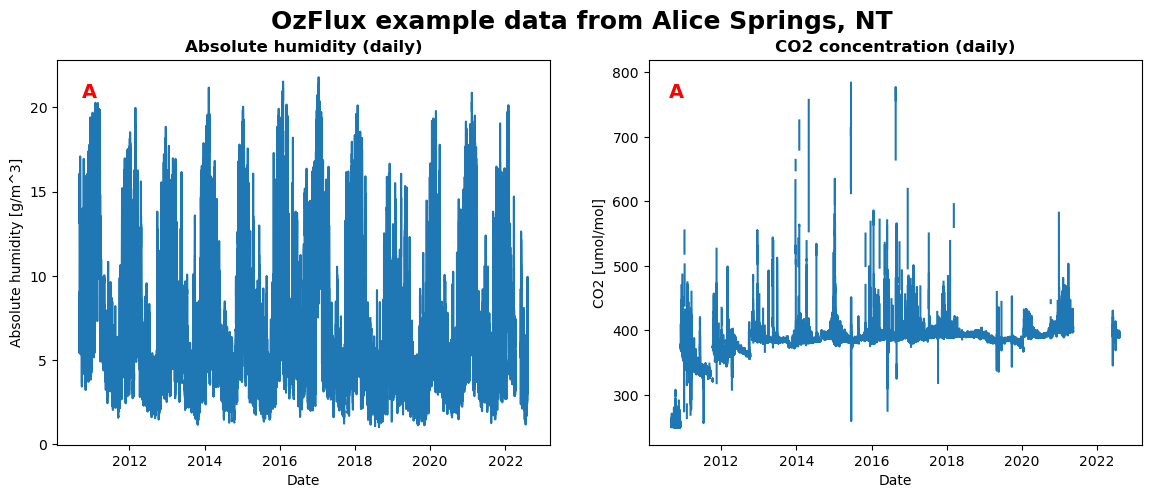

In [7]:
# Create a (2,1) subplot for the two loaded measurements (humidity and CO2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('OzFlux example data from Alice Springs, NT',fontsize=18, fontweight='bold')

# Plot the daily humidity measurements into subplot 1
ax1.set_title('Absolute humidity (daily)',fontweight='bold')
# OzFlux data records time as 'days since 1-1-1800'. To convert to calendar years:
ax1.set_xticks([76701, 77431, 78162, 78892, 79623, 80353, 81084],\
           [2010, 2012, 2014, 2016, 2018, 2020, 2022]) 
ax1.set_xlabel('Date')
ax1.set_ylabel('Absolute humidity [g/m^3]')
ax1.text(0.05, 0.9, 'A', transform=ax1.transAxes, fontsize=14, fontweight='bold', color='r')
ax1.plot(t_AS,AH_AS)

# Plot the daily CO2 measurements into subplot 2
ax2.set_title('CO2 concentration (daily)',fontweight='bold')
# OzFlux data records time as 'days since 1-1-1800'. To convert to calendar years:
ax2.set_xticks([76701, 77431, 78162, 78892, 79623, 80353, 81084],\
           [2010, 2012, 2014, 2016, 2018, 2020, 2022]) 
ax2.set_xlabel('Date')
ax2.set_ylabel('CO2 [umol/mol]')
ax2.text(0.04, 0.9, 'A', transform=ax2.transAxes, fontsize=14, fontweight='bold', color='r')
ax2.plot(t_AS,CO2_AS)

# Save complete figure in the specified save_folder
plt.savefig(save_folder+'OzFlux_daily_AS.png', dpi=200)

And lastly, we execute the same code for Cape Tribulation

In [8]:
AH_CT = np.squeeze(dataset.variables['AH'][:]) # Humidity
CO2_CT = np.squeeze(dataset.variables['CO2'][:]) # CO2 concentration

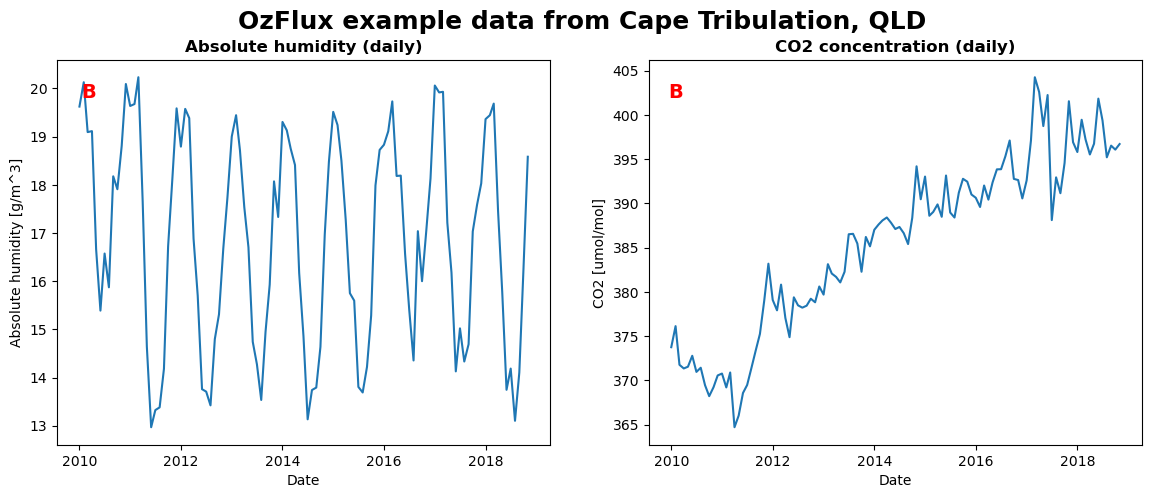

In [9]:
# Create a (2,1) subplot for the two loaded measurements (humidity and CO2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('OzFlux example data from Cape Tribulation, QLD',fontsize=18, fontweight='bold')

# Plot the daily humidity measurements into subplot 1
ax1.set_title('Absolute humidity (daily)',fontweight='bold')
# OzFlux data records time as 'days since 1-1-1800'. To convert to calendar years:
ax1.set_xticks([76701, 77431, 78162, 78892, 79623, 80353, 81084],\
           [2010, 2012, 2014, 2016, 2018, 2020, 2022]) 
ax1.set_xlabel('Date')
ax1.set_ylabel('Absolute humidity [g/m^3]')
ax1.text(0.05, 0.9, 'B', transform=ax1.transAxes, fontsize=14, fontweight='bold', color='r')
ax1.plot(t_CT,AH_CT)

# Plot the daily CO2 measurements into subplot 2
ax2.set_title('CO2 concentration (daily)',fontweight='bold')
# OzFlux data records time as 'days since 1-1-1800'. To convert to calendar years:
ax2.set_xticks([76701, 77431, 78162, 78892, 79623, 80353, 81084],\
           [2010, 2012, 2014, 2016, 2018, 2020, 2022]) 
ax2.set_xlabel('Date')
ax2.set_ylabel('CO2 [umol/mol]')
ax2.text(0.04, 0.9, 'B', transform=ax2.transAxes, fontsize=14, fontweight='bold', color='r')
ax2.plot(t_CT,CO2_CT)

# Save complete figure in the specified save_folder
plt.savefig(save_folder+'OzFlux_daily_CT.png', dpi=200)